# Config

In [ ]:
# # Set dark mode as default
# import matplotlib.pyplot as plt
# import plotly.io as pio
# plt.style.use("dark_background")
# pio.templates.default = "plotly_dark"

# Imports
from typing import Callable, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score,
    balanced_accuracy_score
)
from pyts.image import RecurrencePlot, GramianAngularField
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from market_regime.data import get_data
from market_regime.features.image_features import transform_price
from market_regime.features import ImageFeatureBuilder
from market_regime.models import CNNModel
from market_regime.pipelines.base import RegimePipeline

# Data

### data import

In [2]:
# Data import (with labels)
df = get_data()

### data scaling

<Axes: xlabel='trading_date'>

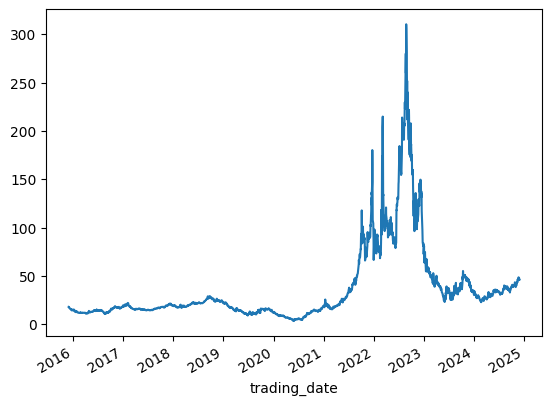

In [3]:
df["close_t"].plot()

<Axes: xlabel='trading_date'>

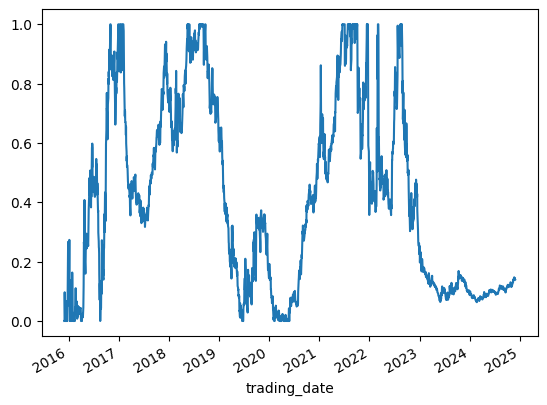

In [4]:
# using min max (needed for GAF, can be used for RP)
(
    (df["close_t"] - df["close_t"].expanding().min())
    / (df["close_t"].expanding().max() - df["close_t"].expanding().min())
).plot()

<Axes: xlabel='trading_date'>

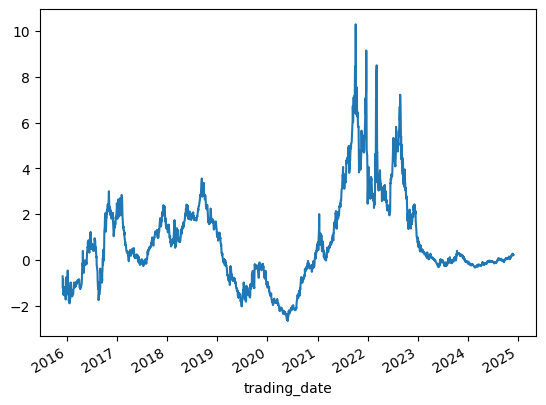

In [5]:
# using z-score (can be used with RP)
((df["close_t"] - df["close_t"].expanding().mean()) / df["close_t"].expanding().std()).plot()

<Axes: xlabel='trading_date'>

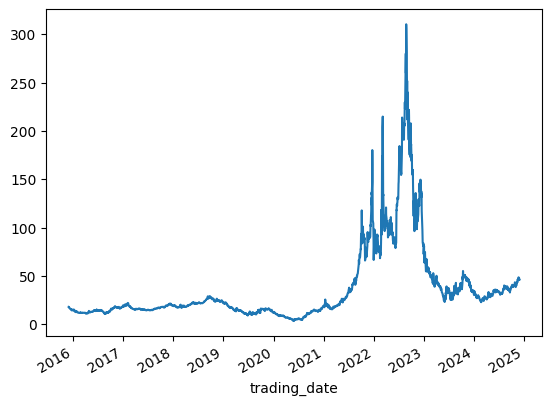

In [6]:
df["close_t"].plot()

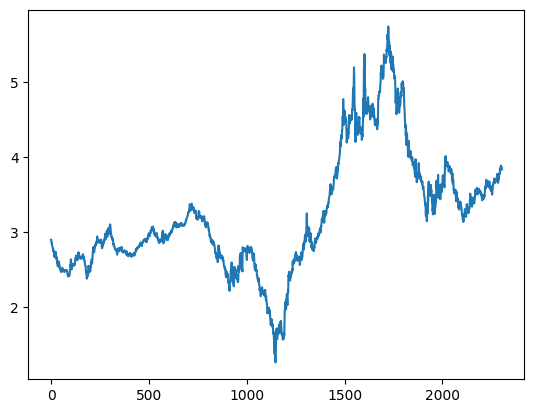

In [7]:
plt.plot(np.log(df["close_t"].to_numpy()))

### recurrence plot

In [8]:
df.shape

(2305, 4)

In [9]:
x = df["close_t"].to_numpy()

In [10]:
x.dtype

dtype('float64')

In [11]:
y = df["target"].to_numpy(dtype=int)

In [12]:
y.dtype

dtype('int64')

In [13]:
x_rp = transform_price(x, scale_method="zscore", keepdims=False)

In [14]:
rp_transformer = RecurrencePlot()
x_rp_t = rp_transformer.fit_transform(x_rp)  # x_rp: (T, window)

In [15]:
x_rp_t.shape

(2246, 60, 60)

In [16]:
x_rp_t[0]

array([[0.        , 0.02201733, 0.21165827, ..., 2.98933296, 3.07290731,
        3.23612929],
       [0.02201733, 0.        , 0.18964094, ..., 2.96731563, 3.05088998,
        3.21411196],
       [0.21165827, 0.18964094, 0.        , ..., 2.7776747 , 2.86124904,
        3.02447102],
       ...,
       [2.98933296, 2.96731563, 2.7776747 , ..., 0.        , 0.08357434,
        0.24679633],
       [3.07290731, 3.05088998, 2.86124904, ..., 0.08357434, 0.        ,
        0.16322198],
       [3.23612929, 3.21411196, 3.02447102, ..., 0.24679633, 0.16322198,
        0.        ]], shape=(60, 60))

### gramian angular field

In [17]:
x_gaf = transform_price(x, scale_method="minmax")

In [18]:
x_gaf.shape

(2246, 60)

In [19]:
x_gaf[:, 1:-2].shape

(2246, 57)

In [20]:
gaf_transformer = GramianAngularField(method='difference')
x_gaf_t = gaf_transformer.fit_transform(x_gaf)

In [21]:
x_gaf_t.shape

(2246, 60, 60)

In [22]:
np.isnan(x_gaf_t).any()

np.False_

# Feature builder

In [23]:
# check if it works
ifb = ImageFeatureBuilder()
x, y, idx, features = ifb.build_features(df, is_train=True)
print(x.shape, y.shape, idx.shape)
print(np.unique(y))

(2246, 2, 60, 60) (2246,) (2246,)
[-1  0  1]


# Single fit on train data

In [41]:
df_train = df[df["delivery_date"] < "2019-01-01"].copy()

In [43]:
ifb = ImageFeatureBuilder()
x_train, y_train, idx_train, _ = ifb.build_features(df, is_train=True)

In [ ]:
# label mapping
Y_TO_INT = {-1: 0, 0: 1, 1: 2}
INT_TO_Y = {0: -1, 1: 0, 2: 1}


def map_y_to_int(y: np.ndarray) -> np.ndarray:
    y = np.asarray(y).ravel()
    uniq = np.unique(y)
    if not np.isin(uniq, [-1, 0, 1]).all():
        raise ValueError(f"Unexpected labels: {uniq.tolist()}")
    return np.vectorize(Y_TO_INT.get, otypes=[int])(y).astype(np.int64)


def map_int_to_y(y_int: np.ndarray) -> np.ndarray:
    y_int = np.asarray(y_int).ravel().astype(int)
    return np.vectorize(INT_TO_Y.get, otypes=[int])(y_int).astype(int)


# CNN definition
class SimpleCNN2Ch(nn.Module):
    """
    Small CNN for 2-channel (RP, GAF) images.
    Global pooling => works for any W.
    """

    def __init__(self, in_ch: int = 2, n_classes: int = 3, dropout: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64, n_classes),
        )

    def forward(self, x):
        return self.net(x)


# Time split
def temporal_train_val_split(x: np.ndarray, y: np.ndarray, val_frac: float = 0.15):
    n = x.shape[0]
    n_val = int(round(n * val_frac))
    n_val = max(1, min(n - 1, n_val))
    x_tr, y_tr = x[:-n_val], y[:-n_val]
    x_va, y_va = x[-n_val:], y[-n_val:]
    return x_tr, y_tr, x_va, y_va


# Training loop
EarlyStopMetric = Literal["val_loss", "macro_f1", "balanced_acc", "acc"]


def train_one_cnn(
    x: np.ndarray,
    y: np.ndarray,
    *,
    val_frac: float = 0.15,
    epochs: int = 10,
    batch_size: int = 64,
    lr: float = 3e-4,
    weight_decay: float = 1e-4,
    patience: int = 2,
    seed: int = 333,
    device: str | None = None,
    balanced_batches: bool = False,
    early_stop_metric: EarlyStopMetric = "val_loss",
    use_class_weights_in_loss: bool = True,
):
    # basic checks
    x = np.asarray(x, dtype=np.float32)
    if x.ndim != 4 or x.shape[1] != 2 or x.shape[2] != x.shape[3]:
        raise ValueError(f"Expected x shape (N,2,W,W). Got {x.shape}")
    y_int = map_y_to_int(y)

    # reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # split
    x_tr, y_tr, x_va, y_va = temporal_train_val_split(x, y_int, val_frac=val_frac)

    # tensors
    Xtr = torch.from_numpy(x_tr).to(device)
    Ytr = torch.from_numpy(y_tr).to(device)
    Xva = torch.from_numpy(x_va).to(device)
    Yva = torch.from_numpy(y_va).to(device)

    # model
    model = SimpleCNN2Ch(in_ch=2, n_classes=3, dropout=0.2).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # loss
    if use_class_weights_in_loss:
        counts = np.bincount(y_int, minlength=3).astype(np.float32)
        w = counts.sum() / (3.0 * counts)
        w = torch.tensor(w, dtype=torch.float32, device=device)
        loss_fn = nn.CrossEntropyLoss(weight=w)
        print("class weights (loss):", w.detach().cpu().numpy())
    else:
        loss_fn = nn.CrossEntropyLoss()

    # dataloader (krok 1)
    n = Xtr.shape[0]
    bs = max(8, min(batch_size, n))

    if balanced_batches:
        # inverse frequency weights per sample (computed on train only)
        train_counts = torch.bincount(Ytr, minlength=3).float()
        class_w = (train_counts.sum() / (3.0 * train_counts)).detach().cpu()  # (3,)
        sample_w = class_w[Ytr.detach().cpu()]  # (n_train,)
        sampler = WeightedRandomSampler(
            weights=sample_w,
            num_samples=len(sample_w),
            replacement=True,
        )
        ds = TensorDataset(Xtr, Ytr)
        loader = DataLoader(ds, batch_size=bs, sampler=sampler)
        print("balanced_batches=True, train class_w:", class_w.numpy())
    else:
        ds = TensorDataset(Xtr, Ytr)
        loader = DataLoader(ds, batch_size=bs, shuffle=True)

    # logs
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_balanced_acc": [],
        "val_macro_f1": [],
        "early_stop_metric": early_stop_metric,
    }

    def compute_val_metrics() -> tuple[float, float, float]:
        model.eval()
        with torch.no_grad():
            logits = model(Xva)
            proba = torch.softmax(logits, dim=1).detach().cpu().numpy()
            pred_int = np.argmax(proba, axis=1).astype(int)

        y_true = map_int_to_y(y_va)  # true labels in {-1,0,1}
        y_pred = map_int_to_y(pred_int)  # pred labels in {-1,0,1}

        acc = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro")
        return acc, bacc, f1m

    # early stopping setup (krok 2)
    # "val_loss" => minimize, others => maximize
    if early_stop_metric == "val_loss":
        best_score = float("inf")
        is_better = lambda s, best: (best - s) > 1e-4
        score_name = "val_loss"
    elif early_stop_metric == "macro_f1":
        best_score = -float("inf")
        is_better = lambda s, best: (s - best) > 1e-4
        score_name = "val_macro_f1"
    elif early_stop_metric == "balanced_acc":
        best_score = -float("inf")
        is_better = lambda s, best: (s - best) > 1e-4
        score_name = "val_balanced_acc"
    elif early_stop_metric == "acc":
        best_score = -float("inf")
        is_better = lambda s, best: (s - best) > 1e-4
        score_name = "val_acc"
    else:
        raise ValueError(f"Unknown early_stop_metric={early_stop_metric}")

    best_state = None
    bad_epochs = 0

    for epoch in range(1, epochs + 1):
        model.train()

        total = 0.0
        steps = 0

        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

            total += float(loss.detach().item())
            steps += 1

        train_loss = total / max(1, steps)

        # val loss
        model.eval()
        with torch.no_grad():
            val_logits = model(Xva)
            val_loss = float(loss_fn(val_logits, Yva).item())

        # val metrics
        acc, bacc, f1m = compute_val_metrics()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(acc)
        history["val_balanced_acc"].append(bacc)
        history["val_macro_f1"].append(f1m)

        # choose early stopping score
        if score_name == "val_loss":
            score = val_loss
        elif score_name == "val_macro_f1":
            score = f1m
        elif score_name == "val_balanced_acc":
            score = bacc
        elif score_name == "val_acc":
            score = acc
        else:
            raise RuntimeError("unreachable")

        # early stopping
        if is_better(score, best_score):
            best_score = score
            best_state = {
                k: v.detach().cpu().clone() for k, v in model.state_dict().items()
            }
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(
                    f"Early stopping at epoch={epoch:02d} (best {score_name}={best_score:.5f})"
                )
                break

        print(
            f"epoch={epoch:02d} "
            f"train_loss={train_loss:.5f} val_loss={val_loss:.5f} "
            f"val_acc={acc:.4f} val_bacc={bacc:.4f} val_macro_f1={f1m:.4f}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)

    # final evaluation on val
    model.eval()
    with torch.no_grad():
        proba = torch.softmax(model(Xva), dim=1).cpu().numpy()
        pred_int = np.argmax(proba, axis=1)

    y_val_true = map_int_to_y(y_va)
    y_val_pred = map_int_to_y(pred_int)

    acc = accuracy_score(y_val_true, y_val_pred)
    bacc = balanced_accuracy_score(y_val_true, y_val_pred)
    f1m = f1_score(y_val_true, y_val_pred, average="macro")
    cm = confusion_matrix(y_val_true, y_val_pred, labels=[-1, 0, 1])

    print("\nVAL metrics:")
    print(f"accuracy         = {acc:.4f}")
    print(f"balanced_acc     = {bacc:.4f}")
    print(f"macro_f1         = {f1m:.4f}")
    print("\nConfusion matrix (rows=true, cols=pred; labels=-1,0,1):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_val_true, y_val_pred, labels=[-1, 0, 1]))

    return (
        model,
        history,
        {
            "acc": acc,
            "balanced_acc": bacc,
            "macro_f1": f1m,
            "cm": cm,
            "y_true": y_val_true,
            "y_pred": y_val_pred,
        },
    )

In [ ]:
model, history, out = train_one_cnn(
    x_train,
    y_train,
    lr=1e-4,
    epochs=20,
    patience=5,
    balanced_batches=True,
    early_stop_metric="macro_f1",
    use_class_weights_in_loss=False,
)

balanced_batches=True, train class_w: [0.9371625  0.99738765 1.0748874 ]
epoch=01 train_loss=1.11181 val_loss=1.10391 val_acc=0.3353 val_bacc=0.3269 val_macro_f1=0.2076
epoch=02 train_loss=1.07027 val_loss=1.12246 val_acc=0.3531 val_bacc=0.3618 val_macro_f1=0.2738
epoch=03 train_loss=1.06070 val_loss=1.11798 val_acc=0.3323 val_bacc=0.3397 val_macro_f1=0.2605
epoch=04 train_loss=1.04165 val_loss=1.11998 val_acc=0.2789 val_bacc=0.2823 val_macro_f1=0.2282
epoch=05 train_loss=1.03357 val_loss=1.12574 val_acc=0.3294 val_bacc=0.3357 val_macro_f1=0.2783
epoch=06 train_loss=1.01792 val_loss=1.13665 val_acc=0.3294 val_bacc=0.3359 val_macro_f1=0.2775
epoch=07 train_loss=1.02290 val_loss=1.14976 val_acc=0.3472 val_bacc=0.3543 val_macro_f1=0.3006
epoch=08 train_loss=1.01454 val_loss=1.15538 val_acc=0.2997 val_bacc=0.3046 val_macro_f1=0.2601
epoch=09 train_loss=0.99423 val_loss=1.17239 val_acc=0.3323 val_bacc=0.3395 val_macro_f1=0.2820
epoch=10 train_loss=0.98967 val_loss=1.17226 val_acc=0.3383 val

Sanity check - czy to problem z modelem czy z brakiem informacji w X?

Jak z problemem radzi sobie log reg

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, balanced_accuracy_score

def baseline_logreg_on_images(
    x: np.ndarray,
    y: np.ndarray,
    *,
    val_frac: float = 0.15,
    max_iter: int = 2000,
    C: float = 1.0,
    seed: int = 333,
):
    x = np.asarray(x, dtype=np.float32)
    y_int = map_y_to_int(y)

    # temporal split
    x_tr, y_tr, x_va, y_va = temporal_train_val_split(x, y_int, val_frac=val_frac)

    # flatten: (N, 2, 60, 60) -> (N, 7200)
    Xtr = x_tr.reshape(x_tr.shape[0], -1)
    Xva = x_va.reshape(x_va.shape[0], -1)

    # pipeline: standardize + multinomial logistic regression
    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lr", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=max_iter,
            C=C,
            n_jobs=None,
            random_state=seed,
        )),
    ])

    clf.fit(Xtr, y_tr)

    pred_int = clf.predict(Xva)
    y_true = map_int_to_y(y_va)
    y_pred = map_int_to_y(pred_int)

    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])

    print("\n[Baseline LogisticRegression] VAL metrics:")
    print(f"accuracy         = {acc:.4f}")
    print(f"balanced_acc     = {bacc:.4f}")
    print(f"macro_f1         = {f1m:.4f}")
    print("\nConfusion matrix (rows=true, cols=pred; labels=-1,0,1):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, labels=[-1, 0, 1]))

    return clf, {"acc": acc, "balanced_acc": bacc, "macro_f1": f1m, "cm": cm}

In [57]:
_ = baseline_logreg_on_images(x_train, y_train, val_frac=0.15)

c:\Code\repos\market-regime-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[Baseline LogisticRegression] VAL metrics:
accuracy         = 0.2938
balanced_acc     = 0.2950
macro_f1         = 0.2936

Confusion matrix (rows=true, cols=pred; labels=-1,0,1):
[[27 29 60]
 [28 36 50]
 [32 39 36]]

Classification report:
              precision    recall  f1-score   support

          -1       0.31      0.23      0.27       116
           0       0.35      0.32      0.33       114
           1       0.25      0.34      0.28       107

    accuracy                           0.29       337
   macro avg       0.30      0.29      0.29       337
weighted avg       0.30      0.29      0.29       337



In [ ]:
# powtórka eksperymentu dla roznych seedow
from scipy.stats import binomtest


def run_seed_repeats_cnn(
    x: np.ndarray,
    y: np.ndarray,
    *,
    seeds: list[int],
    lr: float = 1e-4,
    epochs: int = 30,
    patience: int = 7,
    batch_size: int = 64,
    weight_decay: float = 1e-4,
    val_frac: float = 0.15,
    balanced_batches: bool = True,
    early_stop_metric: str = "macro_f1",
    use_class_weights_in_loss: bool = False,
    device: str | None = None,
    run_baseline_lr: bool = True,
):
    # Baseline once (fixed split + fixed seed)
    baseline = None
    if run_baseline_lr:
        _, baseline = baseline_logreg_on_images(
            x, y,
            val_frac=val_frac,
            seed=333,
        )
        print("\nBaseline (LogReg) summary:")
        print({k: float(baseline[k]) for k in ["acc", "balanced_acc", "macro_f1"]})

    rows = []
    for s in seeds:
        print("\n" + "=" * 80)
        print(f"RUN seed={s}")
        model, history, out = train_one_cnn(
            x, y,
            lr=lr,
            epochs=epochs,
            patience=patience,
            batch_size=batch_size,
            weight_decay=weight_decay,
            val_frac=val_frac,
            balanced_batches=balanced_batches,
            early_stop_metric=early_stop_metric,
            use_class_weights_in_loss=use_class_weights_in_loss,
            device=device,
            seed=s,
        )

        rows.append({
            "seed": s,
            "acc": out["acc"],
            "balanced_acc": out["balanced_acc"],
            "macro_f1": out["macro_f1"],
            "epochs_ran": len(history["train_loss"]),
            "best_metric": early_stop_metric,
        })

    df_res = pd.DataFrame(rows).sort_values("seed").reset_index(drop=True)

    # summary stats
    summary = df_res[["acc", "balanced_acc", "macro_f1"]].agg(["mean", "std"]).T
    print("\n" + "#" * 80)
    print("CNN seed repeats summary (mean ± std):")
    for metric in ["macro_f1", "balanced_acc", "acc"]:
        m = summary.loc[metric, "mean"]
        sd = summary.loc[metric, "std"]
        print(f"{metric:>12s}: {m:.4f} ± {sd:.4f}")

    # sign test vs baseline (macro_f1)
    sign_test = None
    if baseline is not None:
        wins = int((df_res["macro_f1"] > baseline["macro_f1"]).sum())
        n = int(df_res.shape[0])
        # two-sided sign test with p=0.5
        pval = float(binomtest(wins, n, 0.5, alternative="two-sided").pvalue)
        sign_test = {"wins": wins, "n": n, "p_value": pval}
        print("\nSign test vs baseline (macro_f1):")
        print(f"wins={wins}/{n}, p-value={pval:.4f}")

    return df_res, summary, baseline, sign_test


In [62]:
seeds = [1, 2, 3, 4, 5]
df_res, summary, baseline, sign_test = run_seed_repeats_cnn(
    x_train,
    y_train,
    seeds=seeds,
    lr=1e-4,
    epochs=30,
    patience=7,
    balanced_batches=True,
    early_stop_metric="macro_f1",
    use_class_weights_in_loss=False,
    run_baseline_lr=True,
)

c:\Code\repos\market-regime-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[Baseline LogisticRegression] VAL metrics:
accuracy         = 0.2938
balanced_acc     = 0.2950
macro_f1         = 0.2936

Confusion matrix (rows=true, cols=pred; labels=-1,0,1):
[[27 29 60]
 [28 36 50]
 [32 39 36]]

Classification report:
              precision    recall  f1-score   support

          -1       0.31      0.23      0.27       116
           0       0.35      0.32      0.33       114
           1       0.25      0.34      0.28       107

    accuracy                           0.29       337
   macro avg       0.30      0.29      0.29       337
weighted avg       0.30      0.29      0.29       337


Baseline (LogReg) summary:
{'acc': 0.29376854599406527, 'balanced_acc': 0.29499889750156894, 'macro_f1': 0.2936233539372337}

RUN seed=1
balanced_batches=True, train class_w: [0.9371625  0.99738765 1.0748874 ]
epoch=01 train_loss=1.08278 val_loss=1.10658 val_acc=0.3412 val_bacc=0.3496 val_macro_f1=0.2718
epoch=02 train_loss=1.06205 val_loss=1.12851 val_acc=0.3769 val_bacc=0.3

In [63]:
df_res

,seed,acc,balanced_acc,macro_f1,epochs_ran,best_metric
0,1,0.370920,0.376438,0.347600,10,macro_f1
1,2,0.364985,0.370096,0.323702,11,macro_f1
2,3,0.338279,0.344335,0.304502,12,macro_f1
3,4,0.356083,0.362885,0.321999,13,macro_f1
4,5,0.409496,0.418819,0.367116,10,macro_f1


In [64]:
summary

,mean,std
acc,0.367953,0.026291
balanced_acc,0.374515,0.027533
macro_f1,0.332984,0.024478


# OOS prediction

In [30]:
H = 20  # label horizon
W = 60  # image window

rp = RegimePipeline(
    feature_builder=ImageFeatureBuilder(),
    estimator=CNNModel(
        lr=1e-4,
        epochs=30,
        patience=7,
        balanced_batches=True,
        early_stop_metric="macro_f1",
        seed=333,
    ),
)

# wcześniejszy start, żeby mieć margines na ogony
oos_days = df[(df["delivery_date"] >= "2018-05-01")].index

preds = []
for d in tqdm(oos_days, desc="OOS Prediction (CNN RP+GAF)"):
    pos = df.index.get_loc(d)

    # historia do okna W + train_end musi istnieć
    if pos < max(W - 1, H + 1):
        continue

    train_end = df.index[pos - (H + 1)]  # ostatni dzień z "pewną" etykietą przed d

    df_train = df.loc[:train_end, :]
    df_test = df.loc[:d, :]

    rp.fit(df_train)
    full_pred = rp.predict(df_test)

    # feature builder może wywalić NaNy i "d" może nie wyjść w idx
    if d in full_pred.index:
        pred = full_pred.loc[[d]]
    else:
        pred = pd.Series([np.nan], index=[d], name="prediction")

    preds.append(pred)

oos_pred = pd.concat(preds).sort_index()

OOS Prediction (CNN RP+GAF):   0%|          | 0/1710 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
y_true = df.loc[oos_pred.index, "target"].astype(int)
y_pred = oos_pred.astype(int)

macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
bal_acc = balanced_accuracy_score(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
cm_df = pd.DataFrame(cm, index=["true_-1", "true_0", "true_1"], columns=["pred_-1", "pred_0", "pred_1"])

print(f"OOS Macro-F1:          {macro_f1:.4f}")
print(f"OOS Balanced Accuracy: {bal_acc:.4f}\n")

print("Confusion matrix (rows=true, cols=pred):")
display(cm_df)

print("\nClass distribution:")
print("y_true:\n", y_true.value_counts(normalize=True).sort_index())
print("\ny_pred:\n", y_pred.value_counts(normalize=True).sort_index())

print("\nClassification report:")
print(classification_report(y_true, y_pred, labels=[-1, 0, 1], zero_division=0))

# small preview
oos_eval = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
display(oos_eval.head(20))

OOS Macro-F1:          0.1617
OOS Balanced Accuracy: 0.3327

Confusion matrix (rows=true, cols=pred):


,pred_-1,pred_0,pred_1
true_-1,0,611,4
true_0,0,491,1
true_1,0,430,0



Class distribution:
y_true:
 target
-1    0.400130
 0    0.320104
 1    0.279766
Name: proportion, dtype: float64

y_pred:
 prediction
0    0.996747
1    0.003253
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       615
           0       0.32      1.00      0.49       492
           1       0.00      0.00      0.00       430

    accuracy                           0.32      1537
   macro avg       0.11      0.33      0.16      1537
weighted avg       0.10      0.32      0.16      1537



,y_true,y_pred
trading_date,,
2018-11-30,-1,0
2018-12-03,-1,1
2018-12-04,-1,1
2018-12-05,-1,0
2018-12-06,0,0
2018-12-07,-1,0
2018-12-10,0,0
2018-12-11,0,0
2018-12-12,-1,0
